In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('Introduction_Machine_Learning_Data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [2]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #strategy = constant
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

In [5]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


In [6]:
#CROSS VALIDATION

#Cross-validation gives a more accurate measure of model quality, 
#which is especially important if you are making a lot of modeling decisions. 
#However, it can take longer to run, because it estimates multiple models (one for each fold).

#For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.

#For larger datasets, a single validation set is sufficient. 
#Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [207273.036228   195544.72890525 186907.59467108 152084.99219493
 158236.49133232]


In [7]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
180009.368666316


In [8]:
#Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: 
#note that we no longer need to keep track of separate training and validation sets. 
#So, especially for small datasets, it's a good improvement!

In [21]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    return scores.mean()

In [22]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

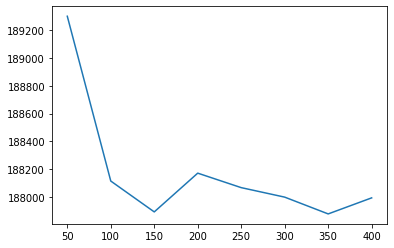

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()